### Predict house price based on features (ML Model)
### London based dtaset

In [19]:
import os
import math
import random

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [20]:
# 1. Load UK Land Registry data
# source: https://www.kaggle.com/datasets/jakewright/house-price-data
csv_path = 'data/kaggle_london_house_price_data.csv'
df =pd.read_csv(csv_path)

print('shape:', df.shape)
df.head()

shape: (418201, 28)


,fullAddress,postcode,country,outcode,latitude,longitude,bathrooms,bedrooms,floorAreaSqM,livingRooms,...,saleEstimate_upperPrice,saleEstimate_confidenceLevel,saleEstimate_ingestedAt,saleEstimate_valueChange.numericChange,saleEstimate_valueChange.percentageChange,saleEstimate_valueChange.saleDate,history_date,history_price,history_percentageChange,history_numericChange
0,"Flat 9, 35 Furnival Street, London, EC4A 1JQ",EC4A 1JQ,England,EC4A,51.517282,-0.110314,1.0,1.0,45.0,1.0,...,630000.0,HIGH,2024-10-07T13:26:59.894Z,244000.0,68.539326,2010-03-30,1995-01-02,830000,NaN,NaN
1,"Flat 6, 35 Furnival Street, London, EC4A 1JQ",EC4A 1JQ,England,EC4A,51.517282,-0.110314,NaN,NaN,NaN,NaN,...,660000.0,MEDIUM,2024-10-07T13:26:59.894Z,425000.0,242.857143,2000-05-26,1995-01-02,830000,NaN,NaN
2,"Flat 35, Octavia House, Medway Street, London,...",SW1P 2TA,England,SW1P,51.495505,-0.132379,2.0,2.0,71.0,1.0,...,834000.0,MEDIUM,2025-01-10T11:04:57.114Z,49000.0,6.901408,2019-09-04,1995-01-03,249950,NaN,NaN
3,"24 Chester Court, Lomond Grove, London, SE5 7HS",SE5 7HS,England,SE5,51.478185,-0.092201,1.0,1.0,64.0,1.0,...,407000.0,HIGH,2024-10-07T13:26:59.894Z,28000.0,7.777778,2024-01-25,1995-01-03,32000,NaN,NaN
4,"18 Alexandra Gardens, London, N10 3RL",N10 3RL,England,N10,51.588774,-0.139599,1.0,4.0,137.0,2.0,...,1324000.0,HIGH,2024-10-07T13:26:59.894Z,81000.0,6.864407,2022-12-14,1995-01-03,133000,NaN,NaN


### Explore data and clean

In [21]:
print(df.describe())
print(df.columns)

            latitude      longitude      bathrooms       bedrooms  \
count  418201.000000  418201.000000  340270.000000  377665.000000   
mean       51.507522      -0.101426       1.444265       2.474884   
std         0.056171       0.086930       0.724478       1.160506   
min        51.385708      -0.347055       1.000000       1.000000   
25%        51.464315      -0.155996       1.000000       2.000000   
50%        51.501581      -0.108482       1.000000       2.000000   
75%        51.548515      -0.043582       2.000000       3.000000   
max        51.665823       0.139249       9.000000       9.000000   

        floorAreaSqM    livingRooms  rentEstimate_lowerPrice  \
count  392991.000000  357701.000000            416460.000000   
mean       98.926543       1.282275              3299.054171   
std        55.938911       0.574412              3168.625404   
min        10.000000       1.000000               300.000000   
25%        63.000000       1.000000              1800.0000

In [22]:
# notes on features:
# df.propertyType
# property type is an important categorical feature, but need to convert to correct type first
# rooms = bedrooms + livingrooms
# it makes mmore sense to combine these two features into one 'rooms' feature

In [23]:
### convert to correct types
df['history_date'] = pd.to_datetime(df['history_date'])
df['history_price'] = df['history_price'].astype(float)

# remove 'bad' data
df = df.dropna(subset=['history_price','history_date'])
df = df.sort_values(by=['history_date'])

# filter out outliers, 2_000_000 GBP seems reasonable for London housing market
min_price= 50_000
max_price = 2_000_000

df = df[df['history_price'] <= max_price]
df = df[df['history_price'] >= min_price]

cols = [
    'history_date', 
    'history_price', 
    'bedrooms', 
    'livingRooms', 
    'bathrooms', 
    'floorAreaSqM', 
    'latitude', 
    'longitude',
    'propertyType'
    ]

df_model= df[cols].copy()
# drop rows with missing values in any of the selected columns
df_model= df_model.dropna(subset=["history_date","history_price","floorAreaSqM"])

num_cols=["bedrooms", "livingRooms", "bathrooms", "floorAreaSqM", "latitude", "longitude"]
for col in num_cols:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

df_model['bedrooms']=pd.to_numeric(df_model['bedrooms'], errors='coerce')
df_model['livingRooms']=pd.to_numeric(df_model['livingRooms'], errors='coerce')
df_model['bathrooms']=pd.to_numeric(df_model['bathrooms'], errors='coerce')
df_model['floorAreaSqM']=pd.to_numeric(df_model['floorAreaSqM'], errors='coerce')
df_model['latitude']=pd.to_numeric(df_model['latitude'], errors='coerce')
df_model['longitude']=pd.to_numeric(df_model['longitude'], errors='coerce')

# sorting by date
df_model = df_model.sort_values(by='history_date').reset_index(drop=True)

print('shape after cleaning:', df.shape)

shape after cleaning: (395361, 28)


In [24]:
# feature engineering
# create log price feature
df_model['log_price'] = np.log(df_model['history_price'])
# make make sure log_price is numeric
df_model['log_price'] = pd.to_numeric(df_model['log_price'], errors='coerce')

# engineer rooms feature
# rooms = bedrooms + livingRooms
df_model['rooms'] = df_model['bedrooms'].fillna(0) + df_model['livingRooms'].fillna(0)

df_model['propertyType'] = df_model['propertyType'].astype('category')
df_model['propertyype_cat'] = df_model['propertyType'].cat.codes
ptype_dummies = pd.get_dummies(df_model['propertyype_cat'], prefix='ptype')

df_model = pd.concat([df_model, ptype_dummies], axis=1)

feature_cols = [
    'rooms',
    'bathrooms',
    'floorAreaSqM',
    'latitude',
    'longitude'
] + list(ptype_dummies.columns)

# make sure all feature columns are numeric
df_model[feature_cols] = df_model[feature_cols].apply(pd.to_numeric, errors='coerce')

# drop rows with missing values in feature columns or target
df_model = df_model.dropna(subset=feature_cols + ['log_price'])

# ensure numpy arrays are purely numeric to avoid NaNs or object dtypes
X = df_model[feature_cols].astype(np.float32).to_numpy()
y = df_model['log_price'].astype(np.float32).to_numpy().reshape(-1, 1)

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (312726, 25)
y shape: (312726, 1)


### Training split

In [7]:
n_samples = len(df_model)
train_end = int(n_samples * 0.7)
val_end = int(n_samples * 0.85)

X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

print('Train set:', X_train.shape, y_train.shape)
print('Validation set:', X_val.shape, y_val.shape)
print('Test set:', X_test.shape, y_test.shape)

X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled = X_scaler.transform(X_val)
X_test_scaled = X_scaler.transform(X_test)





Train set: (218908, 25) (218908, 1)
Validation set: (46909, 25) (46909, 1)
Test set: (46909, 25) (46909, 1)


In [8]:
class HousePriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
BATCH_SIZE = 64

train_dataset = HousePriceDataset(X_train_scaled, y_train)
val_dataset = HousePriceDataset(X_val_scaled, y_val)
test_dataset = HousePriceDataset(X_test_scaled, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print('Datasets:', len(train_dataset), len(val_dataset), len(test_dataset))

Datasets: 218908 46909 46909


In [9]:
# Model def
input_dim = X_train.shape[1]

class PricePredictorNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.net=nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 1)
        )    
    def forward(self, x):
        return self.net(x)
    
model = PricePredictorNN(input_dim).to(device)
print(model)

PricePredictorNN(
  (net): Sequential(
    (0): Linear(in_features=25, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [10]:
# training and evaluation functions

mse_loss_fn = nn.MSELoss()
mae_loss_fn = nn.L1Loss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.0001)

def train_epoch(model,dataloader,optimiser,mse_loss_fn,mae_loss_fn,device):
    model.train()
    running_mse, running_mae, n_batches = 0.0, 0.0, 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimiser.zero_grad()
        y_pred = model(X_batch)
        
        mse_loss = mse_loss_fn(y_pred, y_batch)
        mae_loss = mae_loss_fn(y_pred, y_batch)
        
        loss = mse_loss
        loss.backward()
        optimiser.step()
        
        running_mse += mse_loss.item()
        running_mae += mae_loss.item()
        n_batches += 1

    return running_mse / n_batches, running_mae / n_batches

@torch.no_grad()
def eval_model(model,dataloader,mse_loss_fn,mae_loss_fn,device):
    model.eval()
    running_mse, running_mae, n_batches = 0.0, 0.0, 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        y_pred = model(X_batch)
        
        mse_loss = mse_loss_fn(y_pred, y_batch)
        mae_loss = mae_loss_fn(y_pred, y_batch)
        
        running_mse += mse_loss.item()
        running_mae += mae_loss.item()
        n_batches += 1

    return running_mse / n_batches, running_mae / n_batches


In [11]:
print(model)

PricePredictorNN(
  (net): Sequential(
    (0): Linear(in_features=25, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [12]:
# Training loop

NUM_EPOCHS = 10

train_mse_hist, val_mse_hist = [], []
train_mae_hist, val_mae_hist = [], []

for epoch in range(1, NUM_EPOCHS + 1):
    train_mse, train_mae = train_epoch(model, train_loader, optimiser, mse_loss_fn, mae_loss_fn, device)
    val_mse, val_mae = eval_model(model, val_loader, mse_loss_fn, mae_loss_fn, device)
    
    train_mse_hist.append(train_mse)
    val_mse_hist.append(val_mse)
    train_mae_hist.append(train_mae)
    val_mae_hist.append(val_mae)
    
    if epoch % 5 == 0 or epoch == 1:
        print(f'Epoch {epoch}/{NUM_EPOCHS} - '
              f'Train MSE: {train_mse:.4f}, MAE: {train_mae:.4f} | '
              f'Val MSE: {val_mse:.4f}, MAE: {val_mae:.4f}')

Epoch 1/10 - Train MSE: 30.3726, MAE: 3.6209 | Val MSE: 4.5927, MAE: 1.1687
Epoch 5/10 - Train MSE: 1.1166, MAE: 0.8367 | Val MSE: 0.7075, MAE: 0.7705
Epoch 10/10 - Train MSE: 0.5453, MAE: 0.5940 | Val MSE: 0.6067, MAE: 0.7035


In [13]:
# find mdoel training error by checking for NaN or Inf values

print(np.isnan(y_train).sum())
print(np.isinf(y_train).sum())
print(np.isnan(y_val).sum())
print(np.isinf(y_val).sum())
print(np.isnan(y_test).sum())
print(np.isinf(y_test).sum())
print(np.isnan(X_train_scaled).sum())
print(np.isinf(X_train_scaled).sum())

0
0
0
0
0
0
0
0


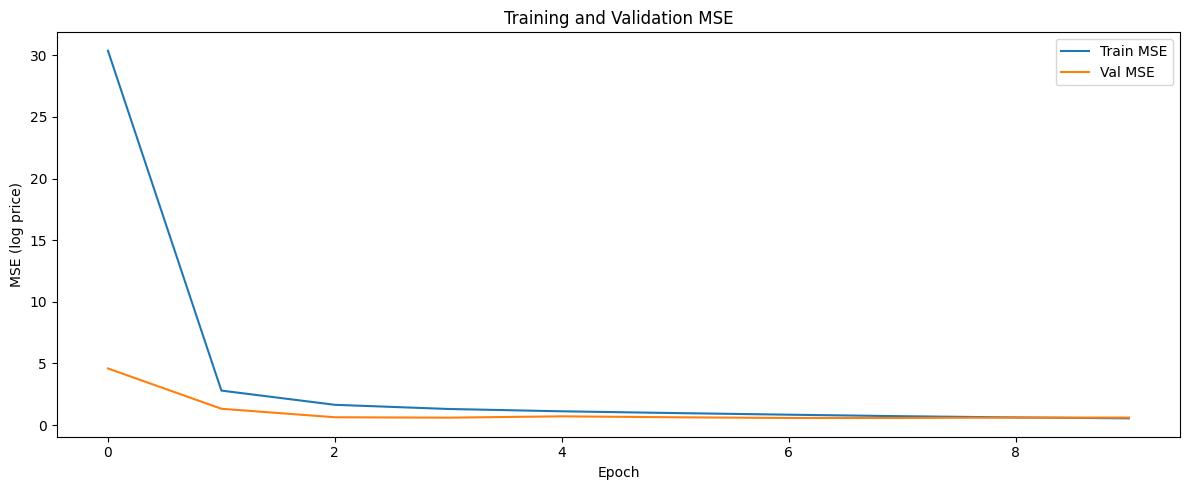

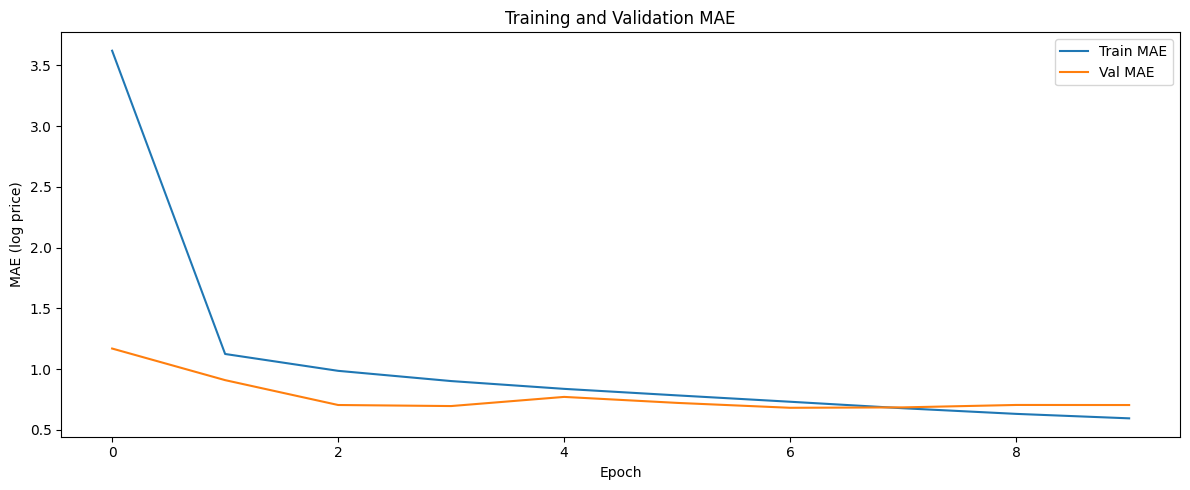

In [14]:
# loss curves

plt.figure(figsize=(12, 5))
plt.plot(train_mse_hist, label='Train MSE')
plt.plot(val_mse_hist, label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE (log price)')
plt.title('Training and Validation MSE')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(train_mae_hist, label='Train MAE')
plt.plot(val_mae_hist, label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE (log price)')
plt.title('Training and Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# evaluate on test set
test_mse, test_mae = eval_model(model, test_loader, mse_loss_fn, mae_loss_fn, device)
print(f'Test MSE (log): {test_mse:.4f}, MAE: {test_mae:.4f}')    

Test MSE (log): 0.5757, MAE: 0.6832


foiltered test set size: 46902
Predicted prices (GBP): [242886.75 255289.22 395761.1  392382.16 434415.28 452591.47 257295.66
 205036.19 267729.44 248853.98]
True: £579,950.25 | Predicted: £242,886.75
True: £620,000.06 | Predicted: £255,289.22
True: £1,050,000.00 | Predicted: £395,761.09
True: £784,999.75 | Predicted: £392,382.16
True: £1,175,000.38 | Predicted: £434,415.28
True: £510,000.06 | Predicted: £452,591.47
True: £425,000.06 | Predicted: £257,295.66
True: £481,999.84 | Predicted: £205,036.19
True: £835,000.12 | Predicted: £267,729.44
True: £390,000.12 | Predicted: £248,853.98


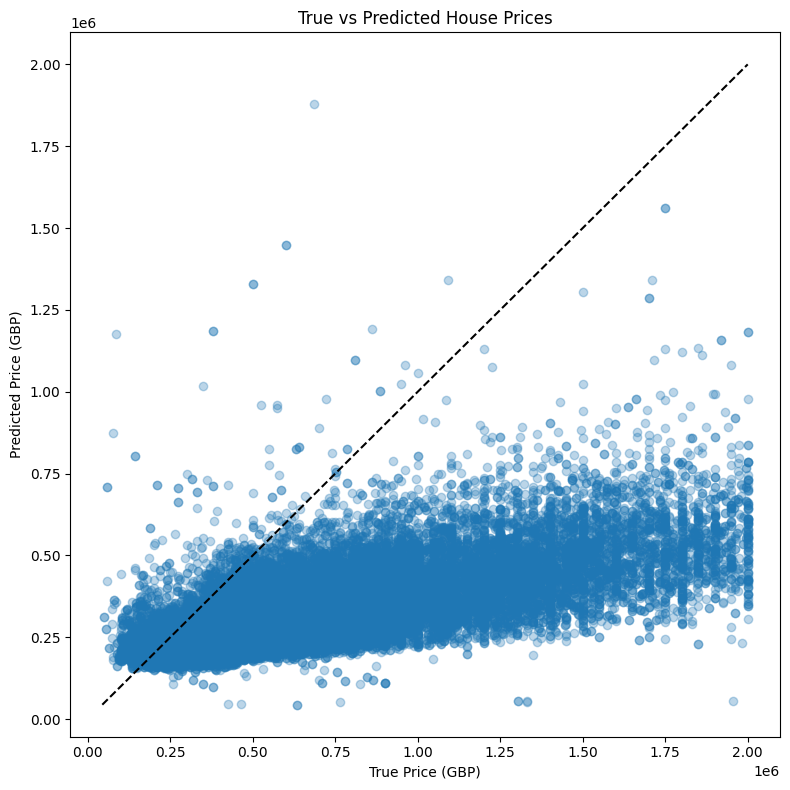

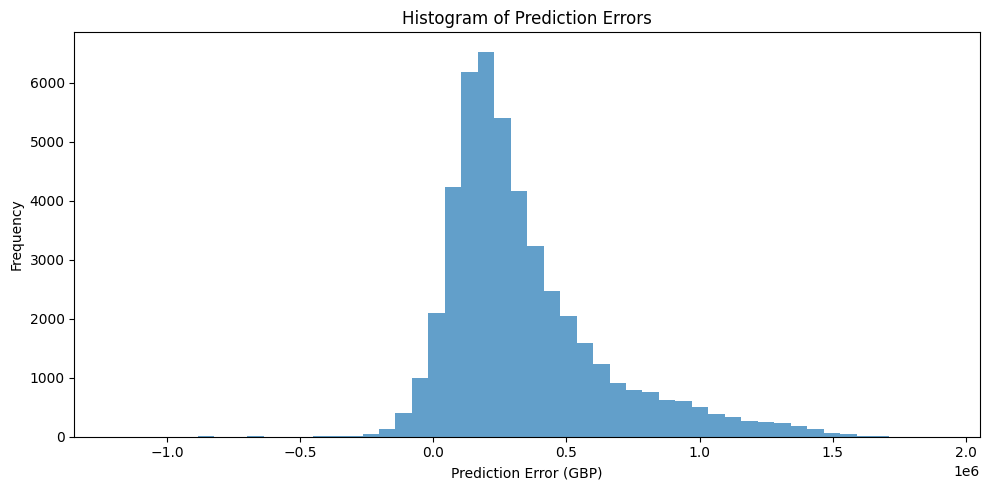

In [16]:
# predict in pounds *GBP*
model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        all_preds.append(y_pred.cpu().numpy())
        all_targets.append(y_batch.numpy())

all_preds = np.vstack(all_preds).ravel()
all_targets = np.vstack(all_targets).ravel()

pred_prices = np.exp(all_preds)
true_prices = np.exp(all_targets)

# remove outliers
mask = (pred_prices <= 2_000_000) & (true_prices <= 2_000_000)
pred_f= pred_prices[mask]
true_f= true_prices[mask]

print("foiltered test set size:", len(true_f))

print('Predicted prices (GBP):', pred_prices[:10])
for t,p in list(zip(true_prices[:10], pred_prices[:10])):
    print(f'True: £{t:,.2f} | Predicted: £{p:,.2f}')

# scatter plot of true vs predicted prices
plt.figure(figsize=(8, 8))
plt.scatter(true_f, pred_f, alpha=0.3)
min_price = min(true_f.min(), pred_f.min())
max_price = max(true_f.max(), pred_f.max())
plt.plot([min_price, max_price], [min_price, max_price], "k--")
plt.xlabel('True Price (GBP)')
plt.ylabel('Predicted Price (GBP)')
plt.title('True vs Predicted House Prices')
plt.tight_layout()
plt.show()

# histogram of prediction errors
residuals = true_f - pred_f
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, alpha=0.7)
plt.xlabel('Prediction Error (GBP)')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.tight_layout()
plt.show()


In [17]:
print(type(df_model))

<class 'pandas.core.frame.DataFrame'>
